# Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
dataset = pd.read_csv('NVDA.csv')
dataset = dataset.dropna()

print(dataset)

           Date        Open        High         Low       Close   Adj Close  \
0    2020-03-12   56.365002   59.029999   53.950001   54.077499   53.899223   
1    2020-03-13   57.625000   60.255001   54.902500   60.209999   60.011513   
2    2020-03-16   53.102501   56.525002   48.500000   49.099998   48.938133   
3    2020-03-17   50.227501   55.215000   47.750000   54.317501   54.138435   
4    2020-03-18   50.025002   52.485001   45.169998   50.705002   50.537842   
..          ...         ...         ...         ...         ...         ...   
995  2024-02-26  797.000000  806.460022  785.049988  790.919983  790.919983   
996  2024-02-27  793.809998  794.799988  771.619995  787.010010  787.010010   
997  2024-02-28  776.200012  789.330017  771.250000  776.630005  776.630005   
998  2024-02-29  790.940002  799.900024  783.500000  791.119995  791.119995   
999  2024-03-01  800.000000  823.000000  794.349976  822.789978  822.789978   

       Volume  
0    81654000  
1    63483600  
2  

In [ ]:
data_date = dataset['Date']
data_prices = dataset['Close']

N = len(data_prices)

print(data_date[0])
print(data_prices)

2020-03-12
0       54.077499
1       60.209999
2       49.099998
3       54.317501
4       50.705002
          ...    
995    790.919983
996    787.010010
997    776.630005
998    791.119995
999    822.789978
Name: Close, Length: 1000, dtype: float64


# Stocks Plot

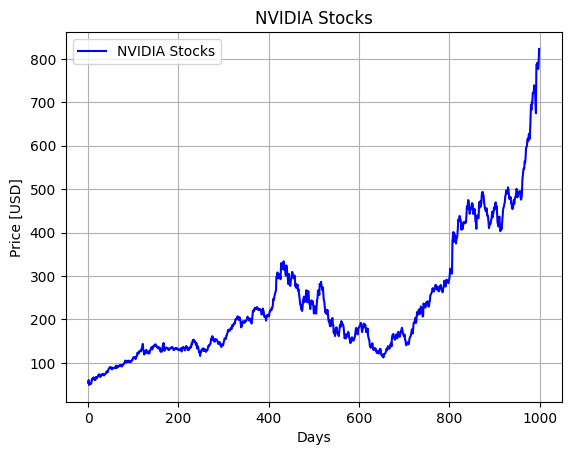

In [ ]:
plt.rcParams.update({'font.size': 10})
plt.plot([x for x in range(N)], data_prices, color="blue", label="NVIDIA Stocks")
plt.title("NVIDIA Stocks")
plt.xlabel('Days')
plt.ylabel('Price [USD]')
plt.grid(True)
plt.legend(loc="upper left")
plt.savefig('ryc1.png')
plt.show()

# Exponential Moving Average

In [ ]:
def calculate_ema(periods, prices):
  alpha = 2 / (periods + 1)
  denominator = sum([(1 - alpha) ** x for x in range(periods+1)])
  ema = np.zeros((len(prices), 2))

  for i in range(periods, len(prices)):
    ema_value = sum([(prices[i-x] * ((1 - alpha) ** x)) for x in range(0, periods+1)])
    ema_value /= denominator
    ema[i][0] = i
    ema[i][1] = ema_value
  return ema

In [ ]:
ema_26 = calculate_ema(26, data_prices)
ema_12 = calculate_ema(12, data_prices)
macd = np.zeros((len(data_prices), 2))
for i in range(len(data_prices)):
  if ema_26[i][0] >= 26 and ema_12[i][0] >= 26:
    macd[i][0] = i
    macd[i][1] = ema_12[i][1] - ema_26[i][1]

signal = calculate_ema(9, macd[:, 1])

transactions = np.zeros((len(data_prices), 4))

for i in range(26 + 1, len(data_prices)):
    if macd[i][1] >= signal[i][1] and macd[i - 1][1] <= signal[i - 1][1]:
        transactions[i] = [i, data_prices[i], 0, signal[i][1]]  # 0 - buy
    elif macd[i][1] <= signal[i][1] and macd[i - 1][1] >= signal[i - 1][1]:
        transactions[i] = [i, data_prices[i], 1, signal[i][1]]  # 1 - sell

transactions_buy = [transaction for transaction in transactions if transaction[2] == 0 and transaction[1] != 0]
transactions_sell = [transaction for transaction in transactions if transaction[2] == 1 and transaction[1] != 0]

transactions_buy = np.array(transactions_buy)
transactions_sell = np.array(transactions_sell)

# MACD+SIGNAL Plot

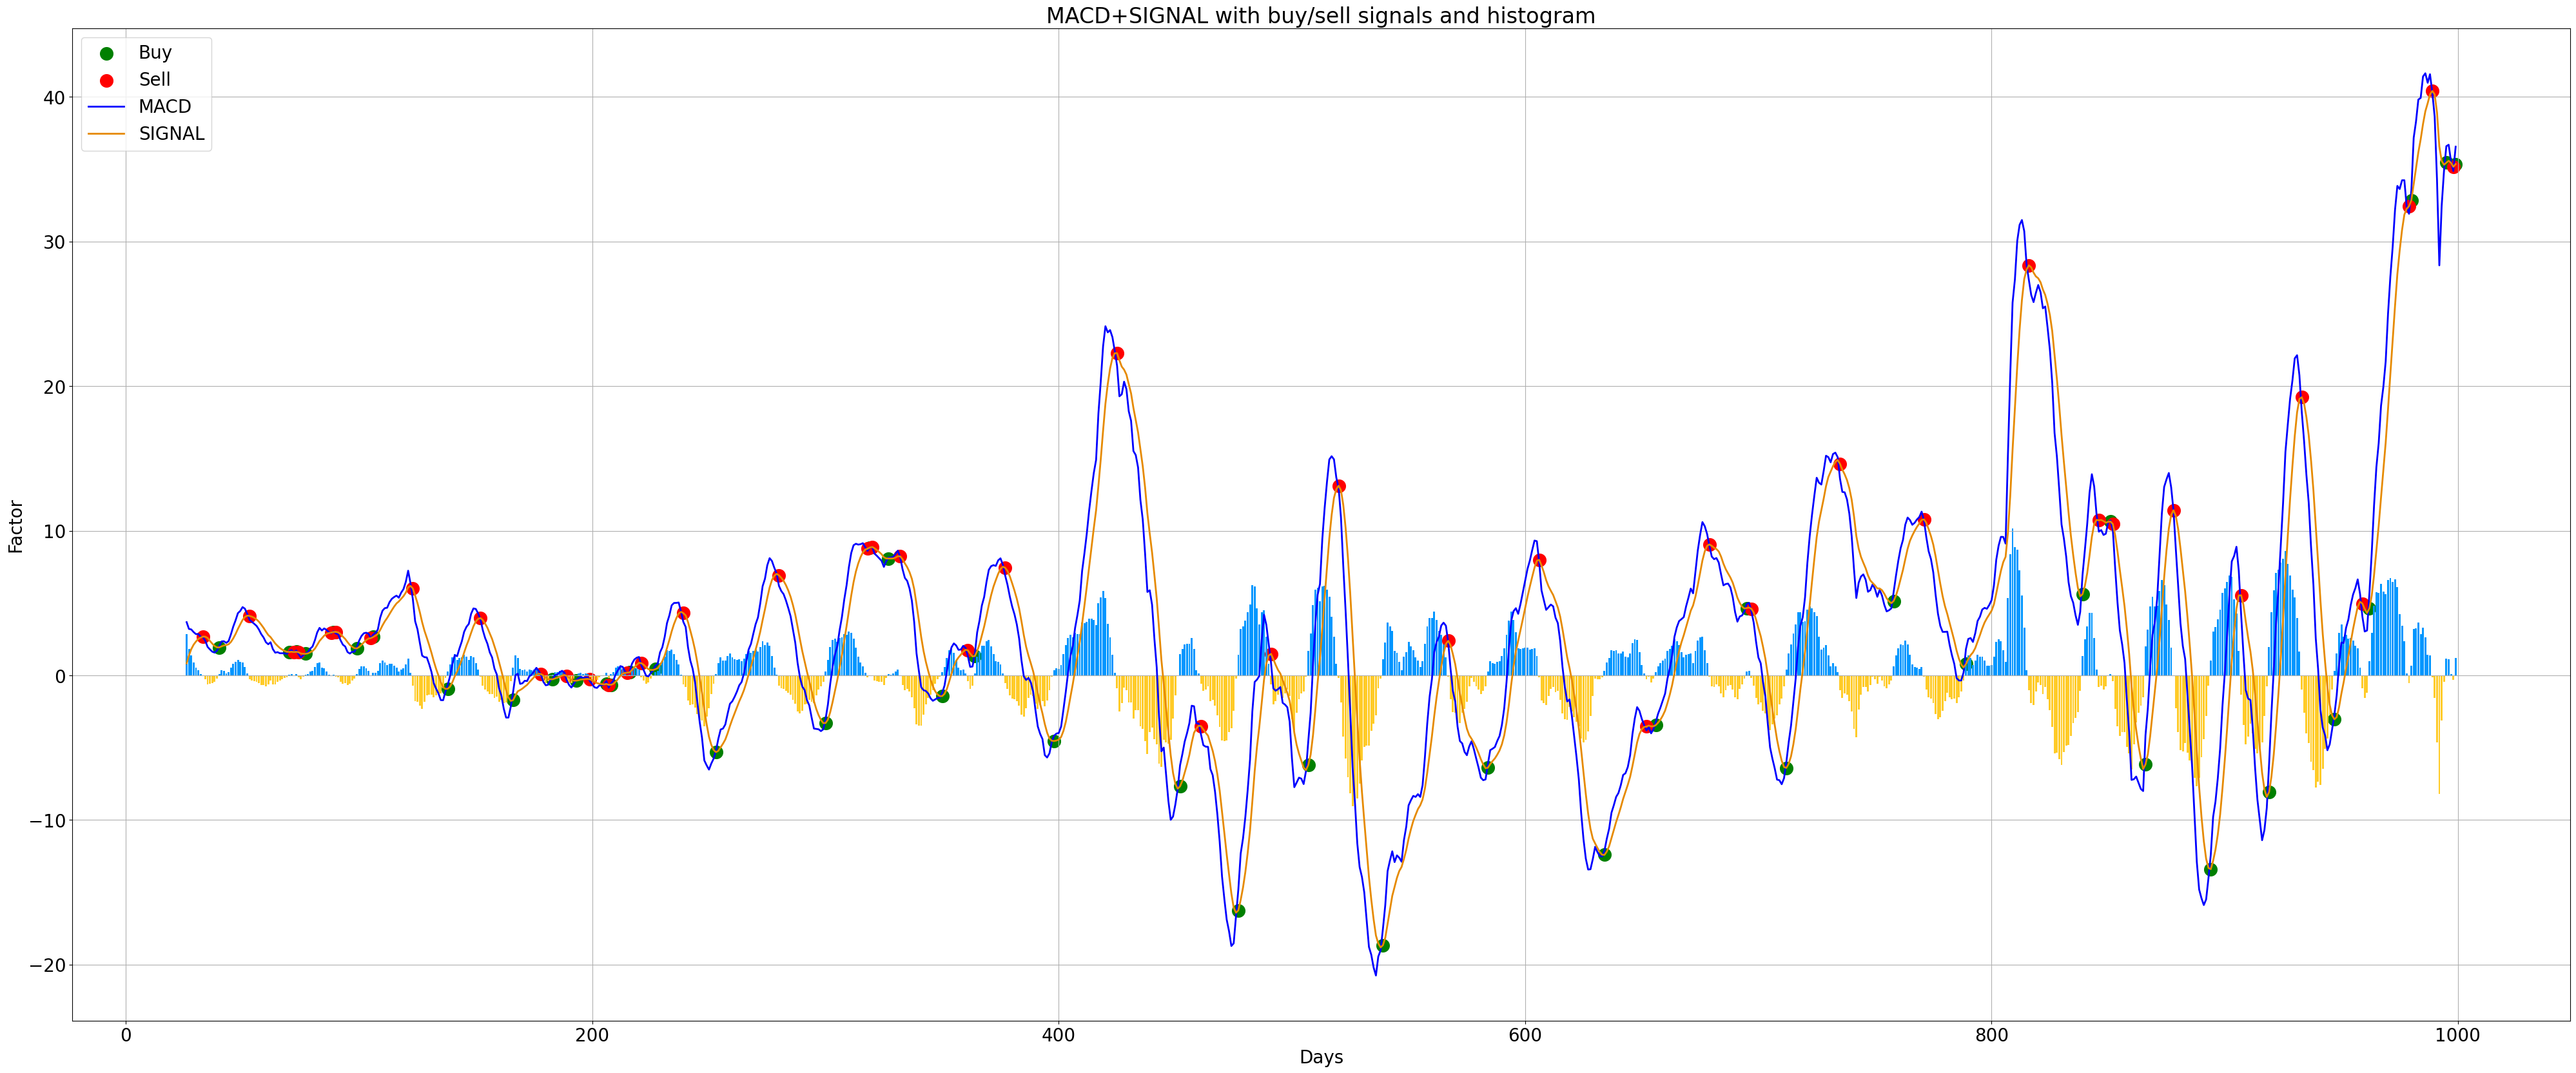

In [ ]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(50,20))

plt.scatter(transactions_buy[:,0], transactions_buy[:,3], color="green", s=200, label="Buy", marker="o")
plt.scatter(transactions_sell[:,0], transactions_sell[:,3], color="red", s=200, label="Sell", marker="o")
plt.plot(macd[26:,0], macd[26:,1], color="blue", label="MACD", linewidth=2.0)
plt.plot(signal[26:,0], signal[26:,1], color="#e68a00", label="SIGNAL", linewidth=2.0)
plt.bar(macd[26:,0][(macd[26:,1]- signal[26:,1]) >= 0], (macd[26:,1]- signal[26:,1])[(macd[26:,1]- signal[26:,1]) >= 0], color="#0096FF")
plt.bar(macd[26:,0][(macd[26:,1]- signal[26:,1]) < 0], (macd[26:,1]- signal[26:,1])[(macd[26:,1]- signal[26:,1]) < 0], color="#FFCB28")
plt.xlabel("Days")
plt.ylabel("Factor")
plt.title('MACD+SIGNAL with buy/sell signals and histogram')
plt.grid(True)
plt.legend(loc="upper left", fontsize="20")
plt.savefig('ryc2.png')
plt.show()

# BUY/SELL Signals with stock prices

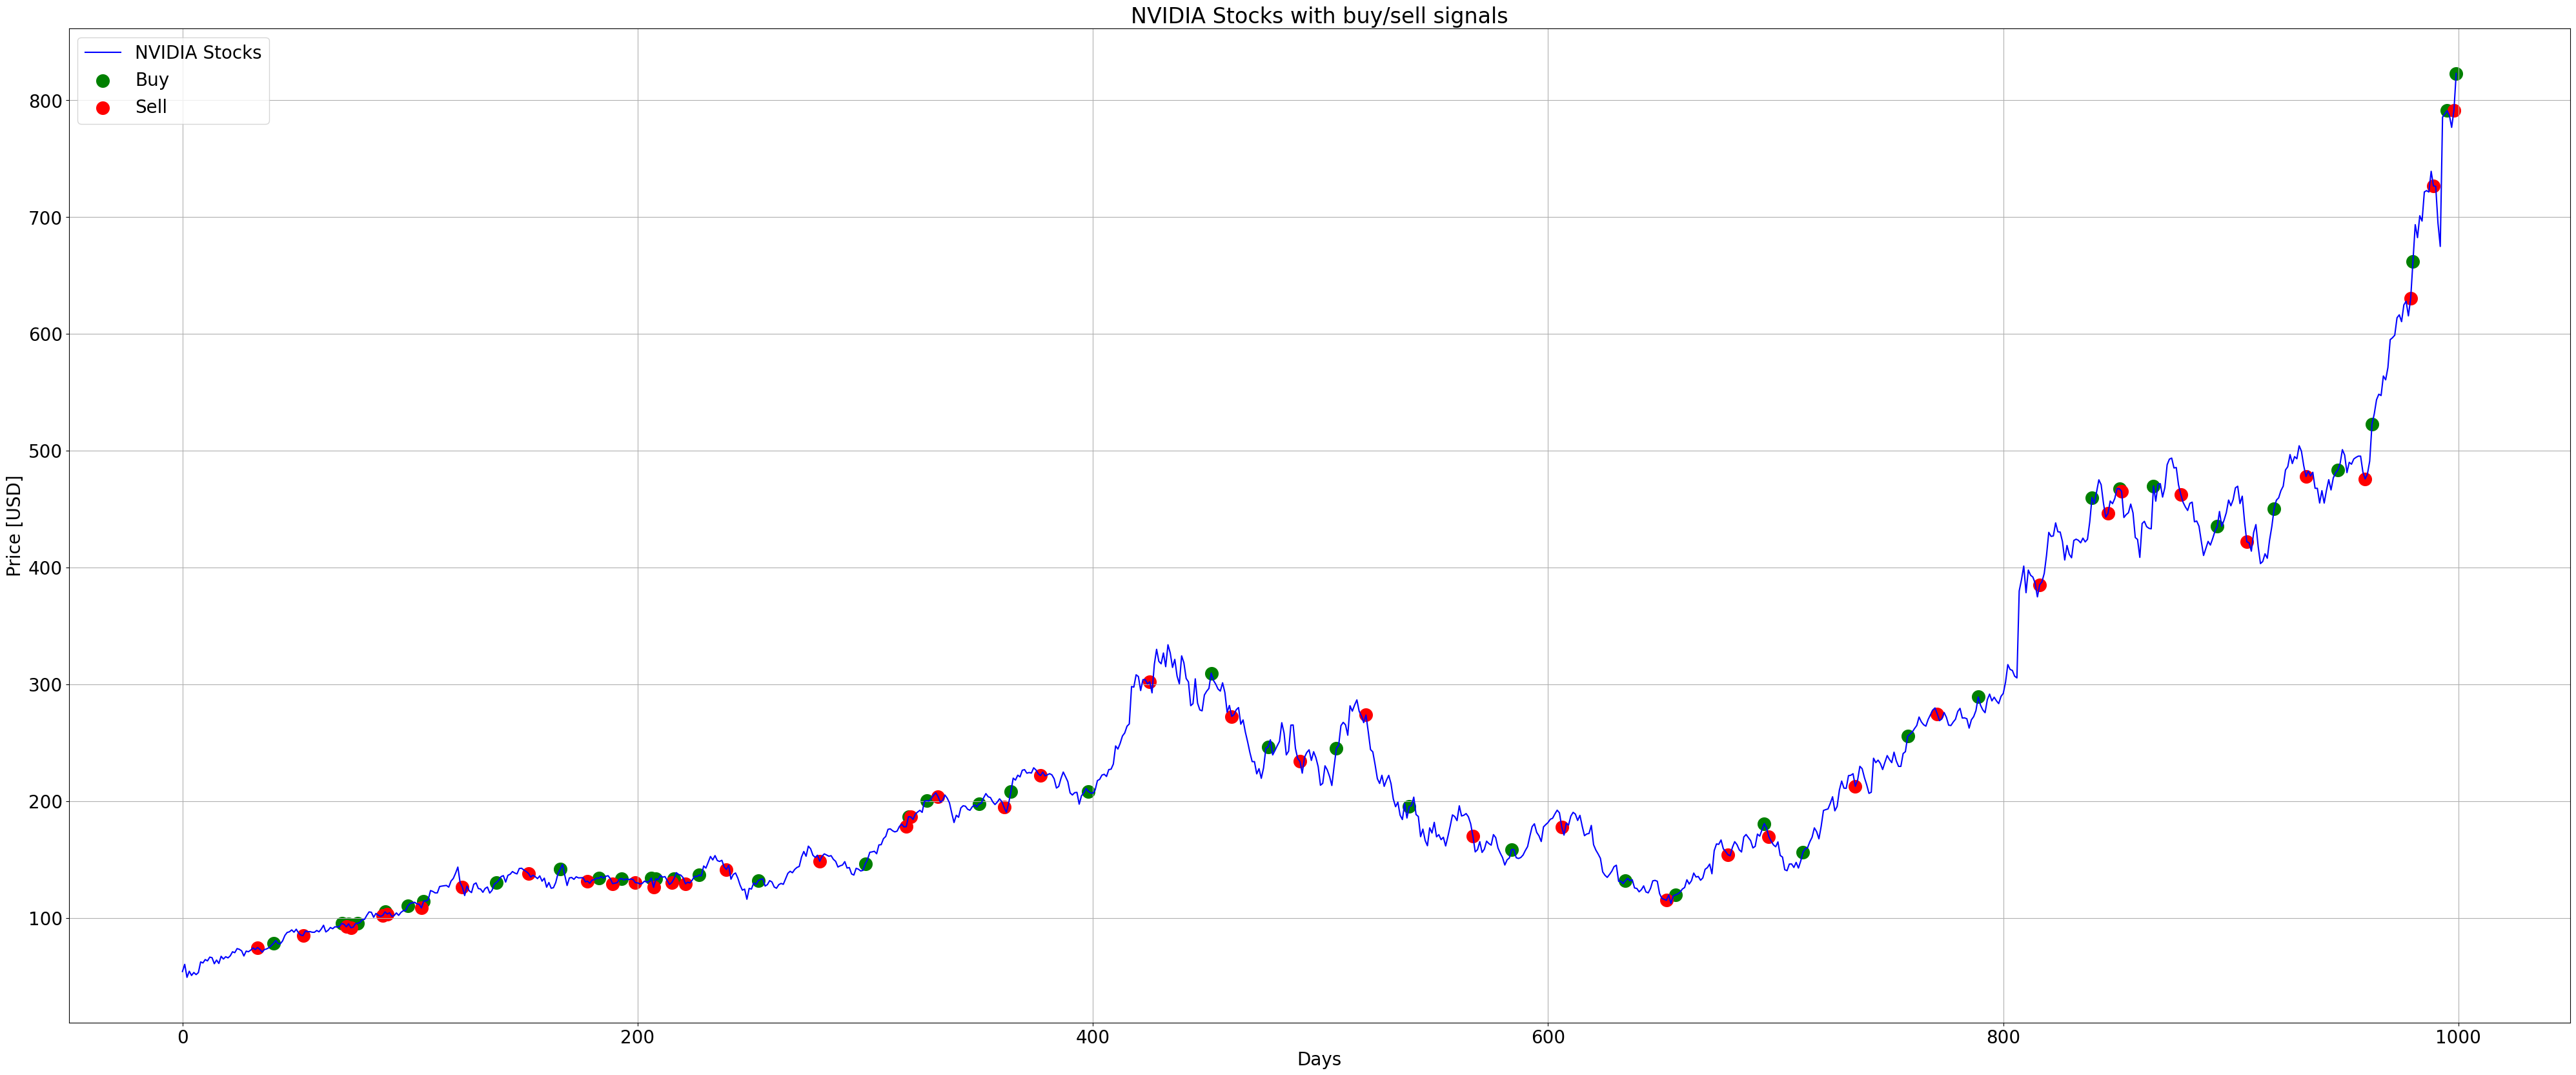

In [ ]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(50,20))
plt.plot([x for x in range(N)], data_prices, color="blue", label="NVIDIA Stocks")
plt.scatter(transactions_buy[:,0], transactions_buy[:,1], color="green", s=200, label="Buy", marker="o")
plt.scatter(transactions_sell[:,0], transactions_sell[:,1], color="red", s=200, label="Sell", marker="o")
plt.title("NVIDIA Stocks with buy/sell signals")
plt.xlabel('Days')
plt.ylabel('Price [USD]')
plt.grid(True)
plt.legend(loc="upper left")
plt.savefig('ryc3.png')
plt.show()

# Short and long term transactions

In [ ]:
start_rate = data_prices[0]
stocks = 1000
balance = 0
wallet_history = [[0, stocks * start_rate, stocks, balance, 'BUY']]
risk_factor = 0.3

for transaction in transactions:
  if transaction[1] != 0 and transaction[2] == 0 and balance > 0: #BUY
    balance_to_spend = balance * risk_factor
    transaction_value =  balance_to_spend / transaction[1]
    balance -= balance_to_spend
    stocks += transaction_value
    wallet_value = stocks * transaction[1] + balance
    wallet_history.append([transaction[0], wallet_value, stocks, balance, 'BUY'])
  elif transaction[1] != 0 and transaction[2] == 1 and stocks > 0: #SELL
    stocks_to_sell = stocks * risk_factor
    transaction_value = stocks_to_sell * transaction[1]
    stocks -= stocks_to_sell
    balance += transaction_value
    wallet_value = stocks * transaction[1] + balance
    wallet_history.append([transaction[0], wallet_value, stocks, balance, 'SELL'])

wallet_history_p1_x = [date[0] for date in wallet_history if date[0] >= 450 and date[0] <= 510]
wallet_history_p1_y = [date[1] for date in wallet_history if date[0] >= 450 and date[0] <= 510]

wallet_history_p2_x = [date[0] for date in wallet_history if date[0] >= 400 and date[0] <= 765]
wallet_history_p2_y = [date[1] for date in wallet_history if date[0] >= 400 and date[0] <= 765]

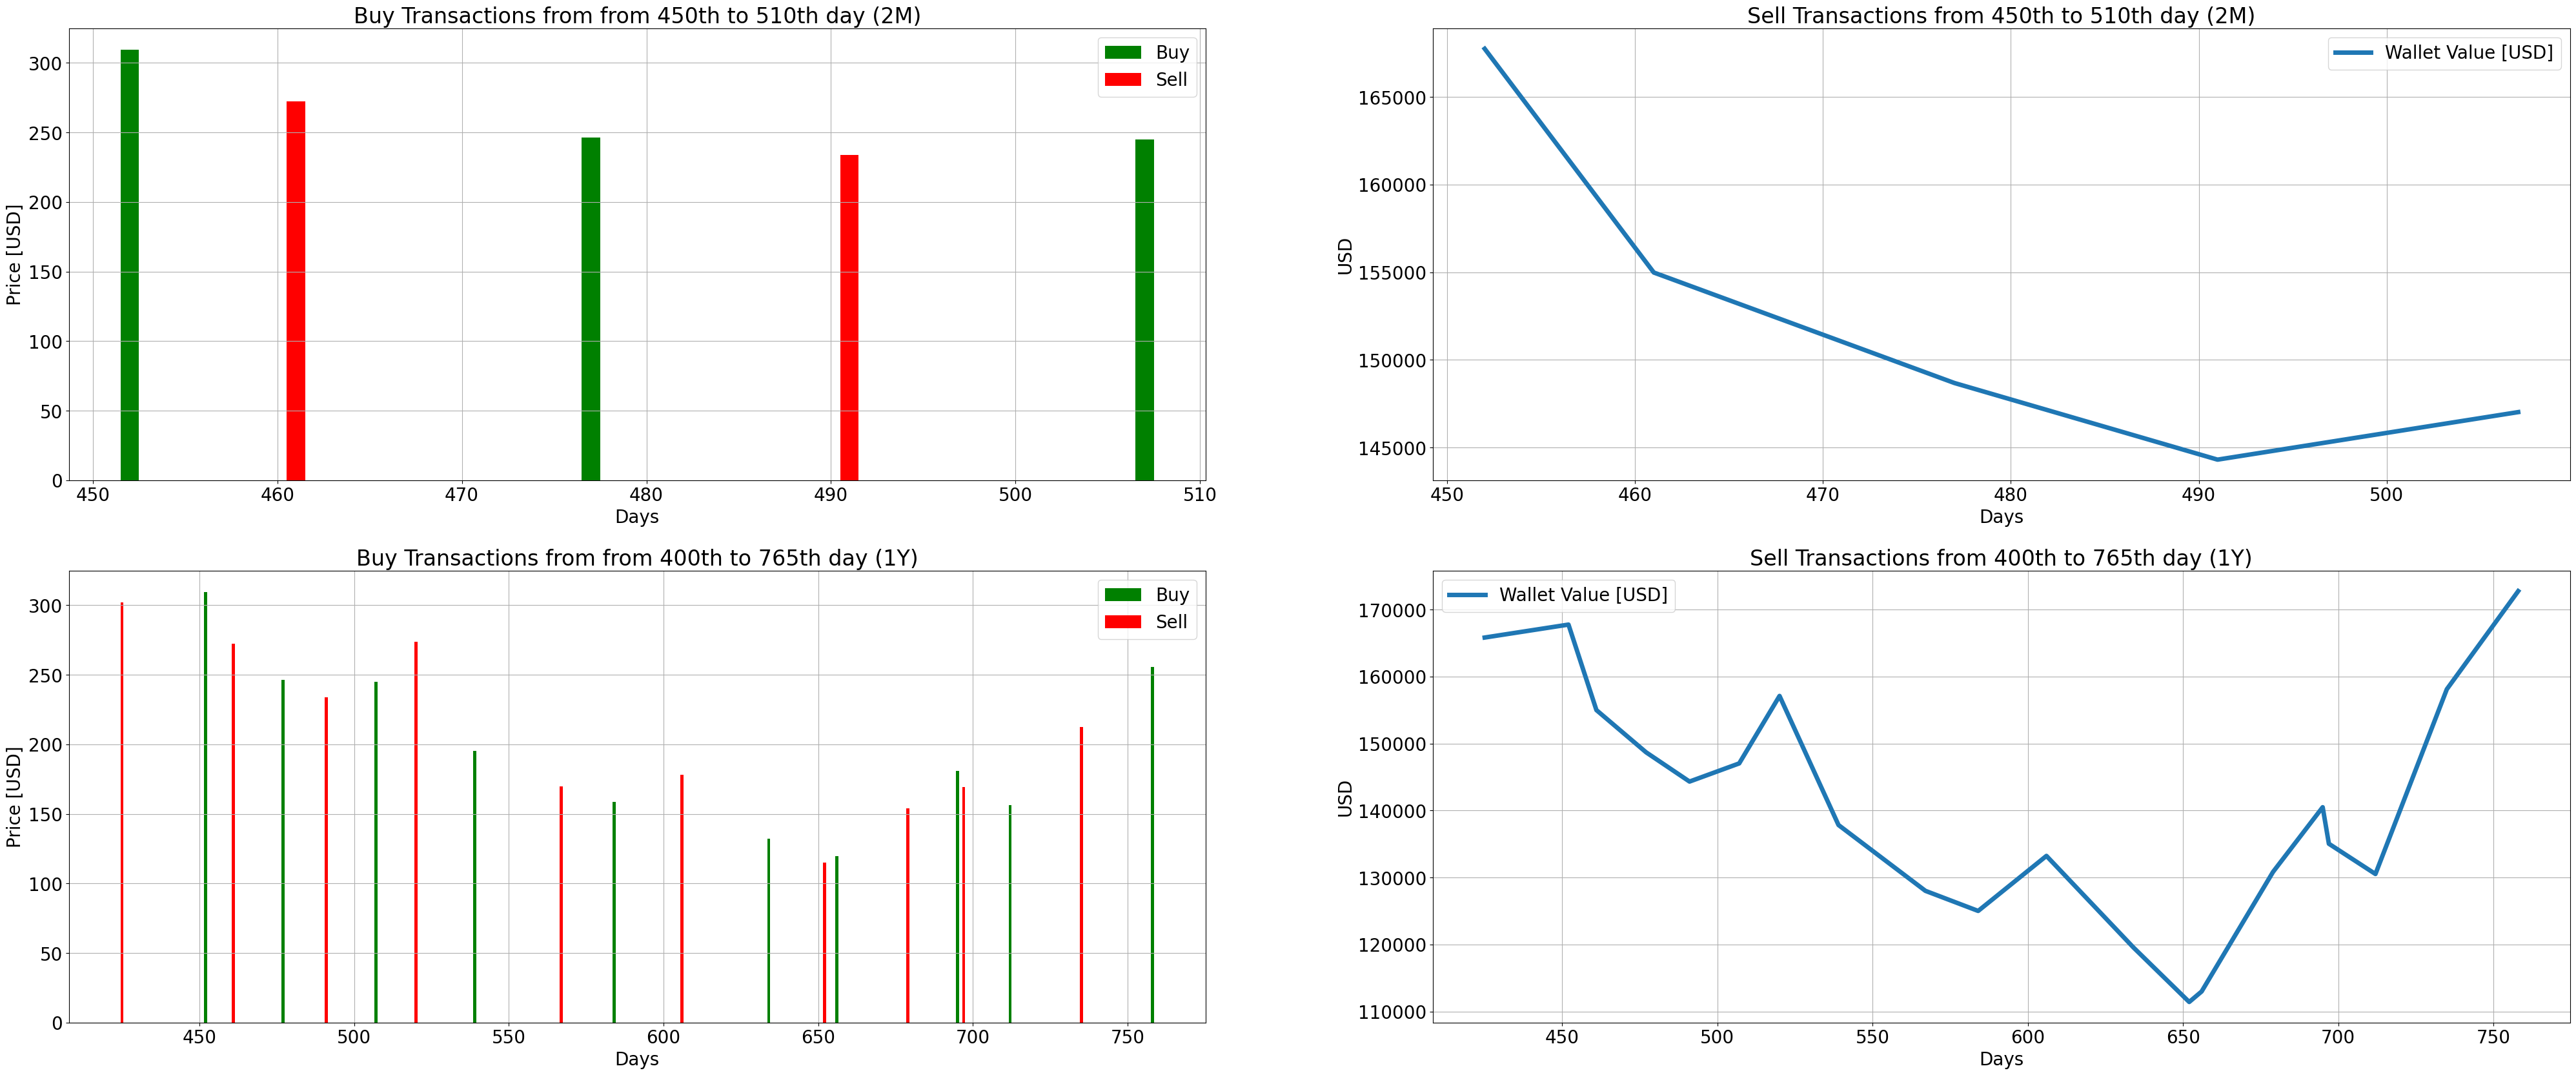

In [ ]:
figure, axis = plt.subplots(2,2)
figure.set_figwidth(50)
figure.set_figheight(20)

axis[0,0].bar([transaction[0] for transaction in transactions if transaction[2] == 0 and transaction[1] != 0 and transaction[0] >= 450 and transaction[0] <= 510], [transaction[1] for transaction in transactions if transaction[2] == 0 and transaction[1] != 0 and transaction[0] >= 450 and transaction[0] <= 510], color="green", width=1, label="Buy")
axis[0,0].bar([transaction[0] for transaction in transactions if transaction[2] == 1 and transaction[1] != 0 and transaction[0] >= 450 and transaction[0] <= 510], [transaction[1] for transaction in transactions if transaction[2] == 1 and transaction[1] != 0 and transaction[0] >= 450 and transaction[0] <= 510],  color="red", width=1, label="Sell")
axis[0,0].grid(True)
axis[0,0].set_xlabel('Days')
axis[0,0].set_ylabel('Price [USD]')
axis[0,0].set_title("Buy Transactions from from 450th to 510th day (2M)")
axis[0,0].legend(loc="upper right", fontsize="20")

axis[0,1].plot(wallet_history_p1_x , wallet_history_p1_y, label="Wallet Value [USD]", linewidth=5.0)
axis[0,1].grid(True)
axis[0,1].set_xlabel('Days')
axis[0,1].set_ylabel('USD')
axis[0,1].set_title("Sell Transactions from 450th to 510th day (2M)")
axis[0,1].legend(loc="upper right", fontsize="20")

axis[1,0].bar([transaction[0] for transaction in transactions if transaction[2] == 0 and transaction[1] != 0 and transaction[0] >= 400 and transaction[0] <= 765], [transaction[1] for transaction in transactions if transaction[2] == 0 and transaction[1] != 0 and transaction[0] >= 400 and transaction[0] <= 765], color="green", width=1, label="Buy")
axis[1,0].bar([transaction[0] for transaction in transactions if transaction[2] == 1 and transaction[1] != 0 and transaction[0] >= 400 and transaction[0] <= 765], [transaction[1] for transaction in transactions if transaction[2] == 1 and transaction[1] != 0 and transaction[0] >= 400 and transaction[0] <= 765],  color="red", width=1, label="Sell")
axis[1,0].grid(True)
axis[1,0].set_xlabel('Days')
axis[1,0].set_ylabel('Price [USD]')
axis[1,0].set_title("Buy Transactions from from 400th to 765th day (1Y)")
axis[1,0].legend(loc="upper right", fontsize="20")

axis[1,1].plot(wallet_history_p2_x , wallet_history_p2_y, label="Wallet Value [USD]", linewidth=5.0)
axis[1,1].grid(True)
axis[1,1].set_xlabel('Days')
axis[1,1].set_ylabel('USD')
axis[1,1].set_title("Sell Transactions from 400th to 765th day (1Y)")
axis[1,1].legend(loc="upper left", fontsize="20")

plt.savefig('ryc4.png')
plt.show()


# Buy/Sell Simulation

In [ ]:
wallet_data = {
    "Date" : [data_date[date[0]] for date in wallet_history],
    "Transaction" : [transaction[4] for transaction in wallet_history],
    "Stocks" : [stocks[2] for stocks in wallet_history],
    "Balance" : [balance[3] for balance in wallet_history],
    "Price" : [data_prices[date[0]] for date in wallet_history],
    "Wallet Value" : [value[1] for value in wallet_history],
    "Daily Profit" : [0] + [wallet_history[i][1] - wallet_history[i-1][1] for i in range(1,len(wallet_history))],
    "History Profit" : [wallet_history[i][1] - wallet_history[0][1] for i in range(len(wallet_history))]
}
df = pd.DataFrame(wallet_data)
display(df)

,Date,Transaction,Stocks,Balance,Price,Wallet Value,Daily Profit,History Profit
0,2020-03-12,BUY,1000.000000,0.000000,54.077499,54077.499000,0.000000,0.000000
1,2020-04-29,SELL,700.000000,22384.499400,74.614998,74614.998000,20537.499000,20537.499000
2,2020-05-08,BUY,785.956478,15669.149580,78.125000,77071.999400,2457.001400,22994.500400
3,2020-05-28,SELL,550.169534,35680.388166,84.870003,82373.278200,5301.278800,28295.779200
4,2020-06-22,BUY,662.528064,24976.271716,95.267502,88093.665384,5720.387184,34016.166384
...,...,...,...,...,...,...,...,...
82,2024-02-02,BUY,282.677926,110768.933607,661.599976,297788.642826,6608.239439,243711.143826
83,2024-02-15,SELL,197.874548,172385.373344,726.580017,316157.066063,18368.423237,262079.567063
84,2024-02-26,BUY,263.261203,120669.761341,790.919983,328888.307778,12731.241714,274810.808778
85,2024-02-29,SELL,184.282842,183151.121892,791.119995,328940.963178,52.655400,274863.464178


In [ ]:
macd_data = {
    "Date" : data_date,
    "MACD" : macd[:,1],
    "Signal" : signal[:,1],
    "NVDA Stocks" : data_prices,
}
df2 = pd.DataFrame(macd_data)
display(df2)

,Date,MACD,Signal,NVDA Stocks
0,2020-03-12,0.000000,0.000000,54.077499
1,2020-03-13,0.000000,0.000000,60.209999
2,2020-03-16,0.000000,0.000000,49.099998
3,2020-03-17,0.000000,0.000000,54.317501
4,2020-03-18,0.000000,0.000000,50.705002
...,...,...,...,...
995,2024-02-26,36.593308,35.452493,790.919983
996,2024-02-27,36.692613,35.581617,787.010010
997,2024-02-28,35.546133,35.443798,776.630005
998,2024-02-29,34.877222,35.169491,791.119995
